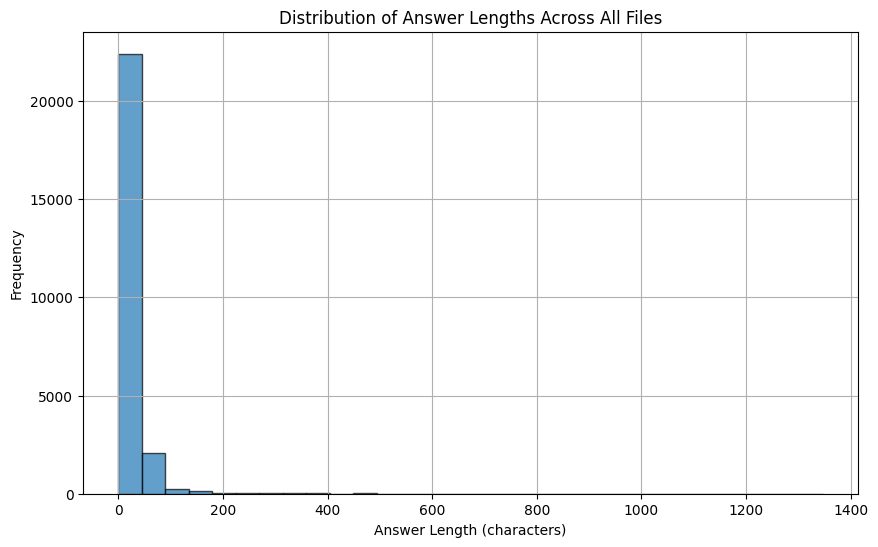

In [1]:
# NOTE: 
# I've been checking the distribution of answer lenghts for 
# fine-tuned models to make a feasible yet sufficiently high assumption
# on max_new_tokens (answer length) in base.py
# --> 250 seems sufficient here for the majority of questions
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts')))
import utils.plotting as p

p.plot_answer_length_distribution('model_results/tuned')

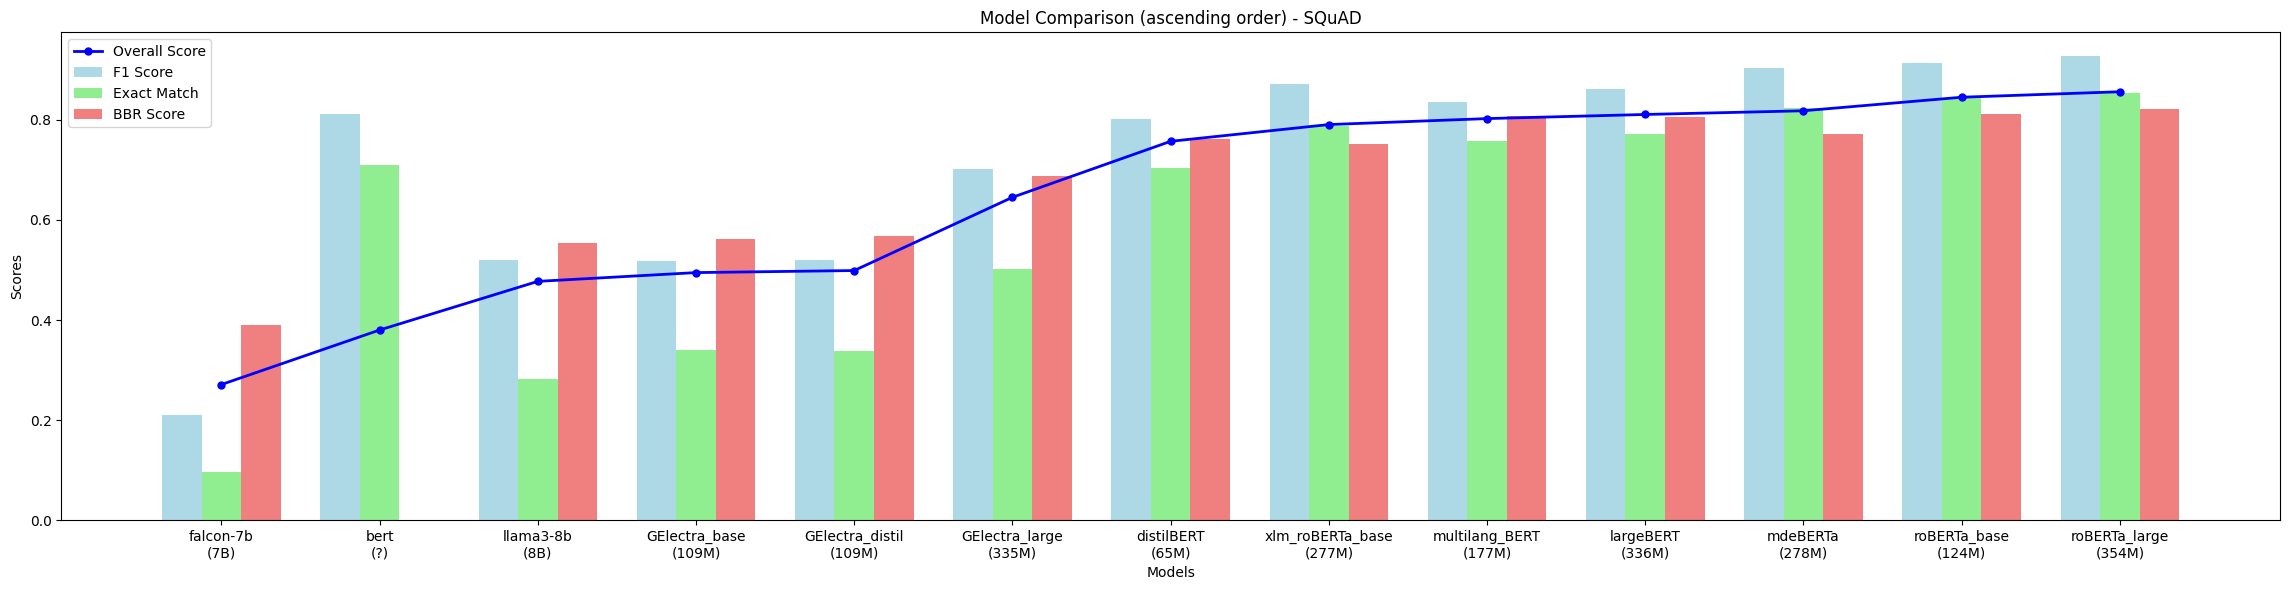

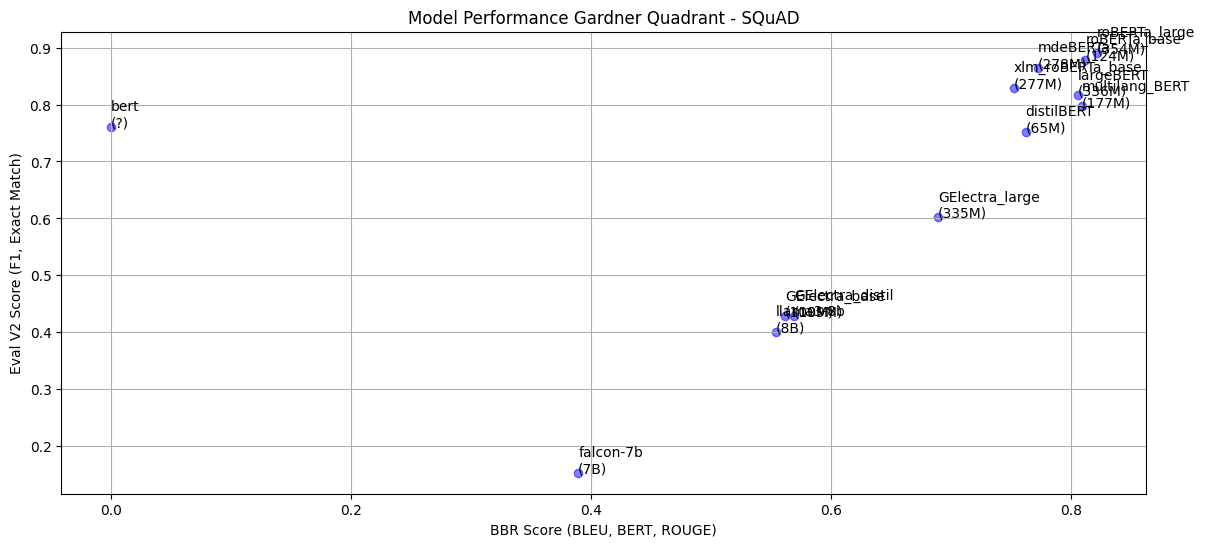

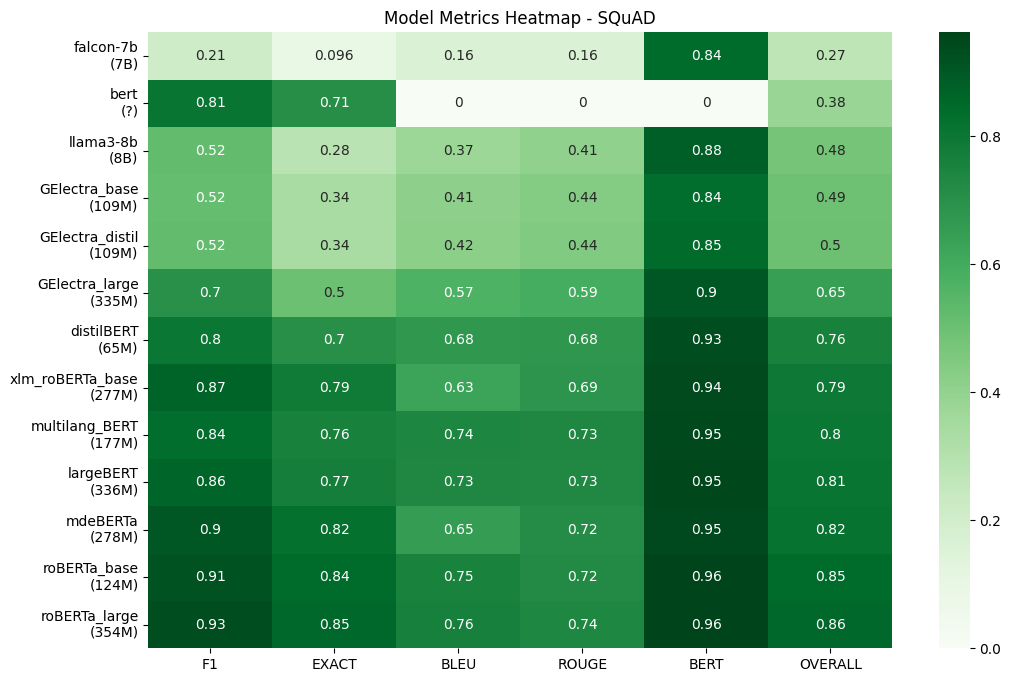

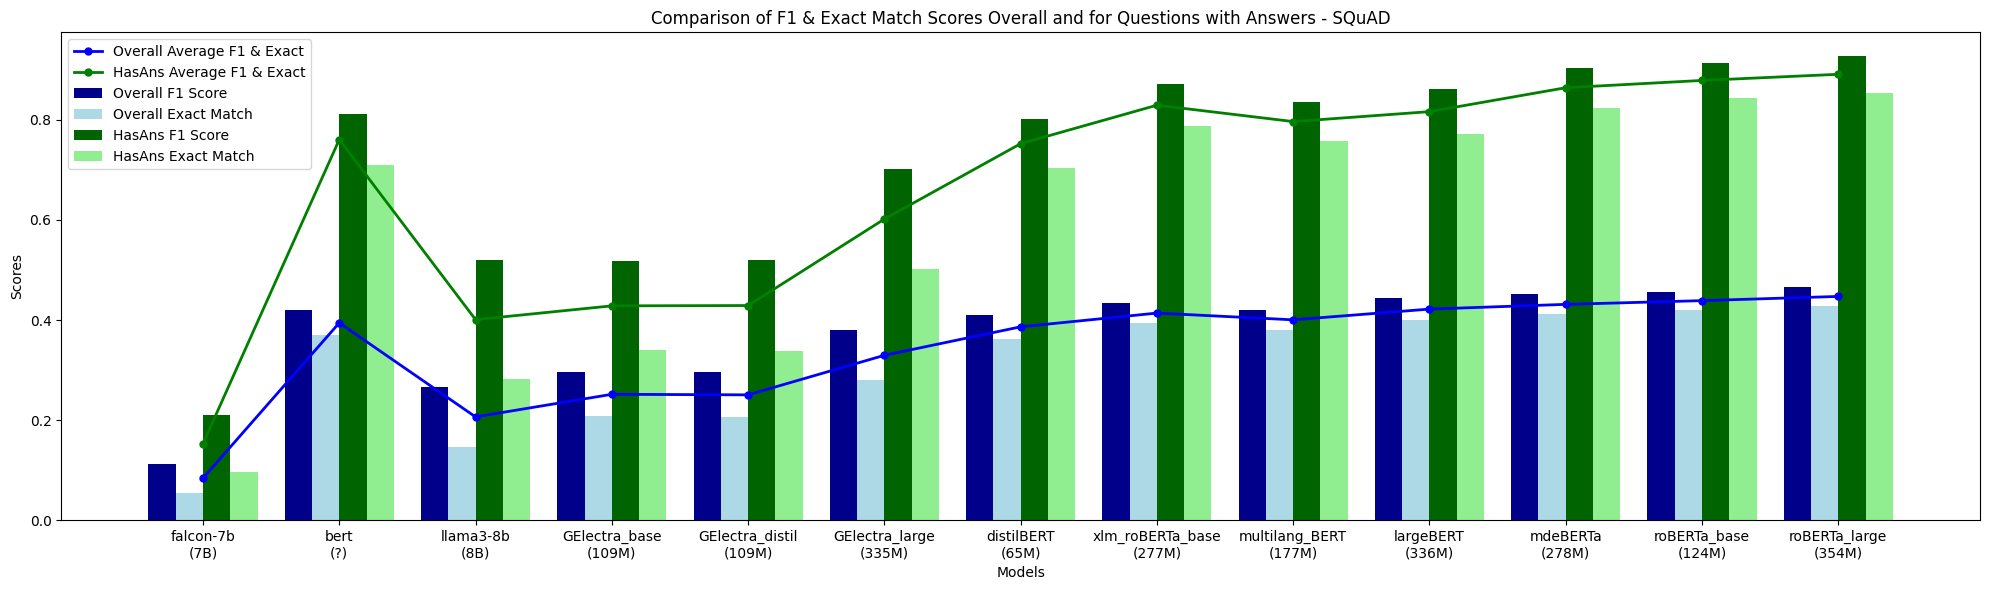

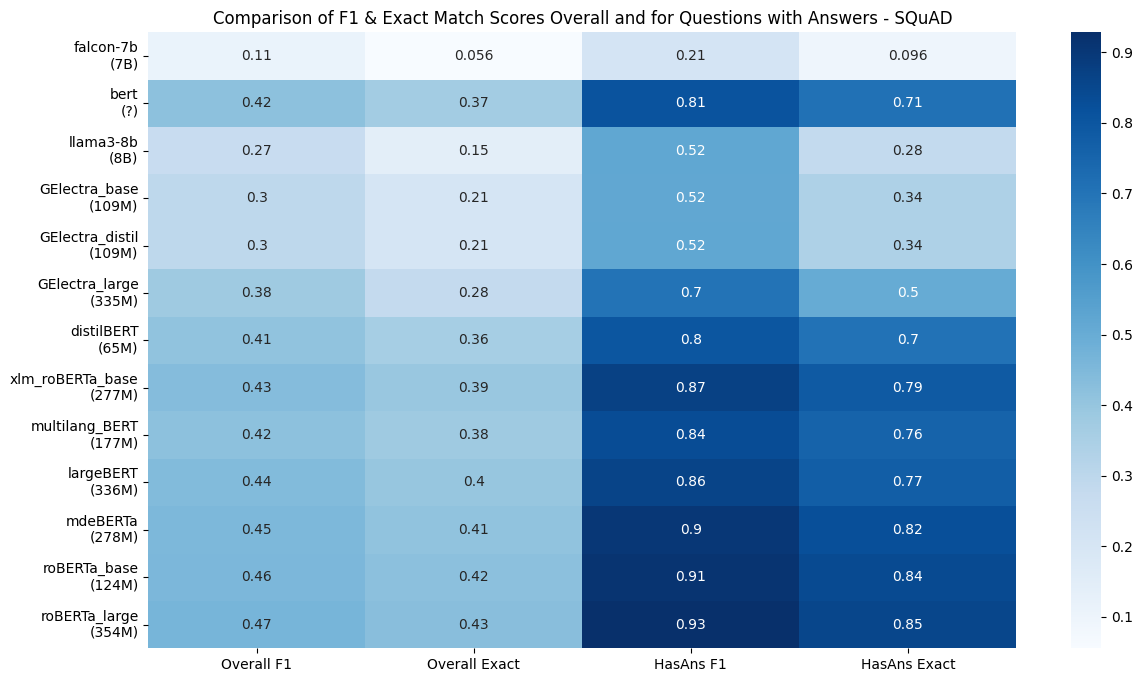

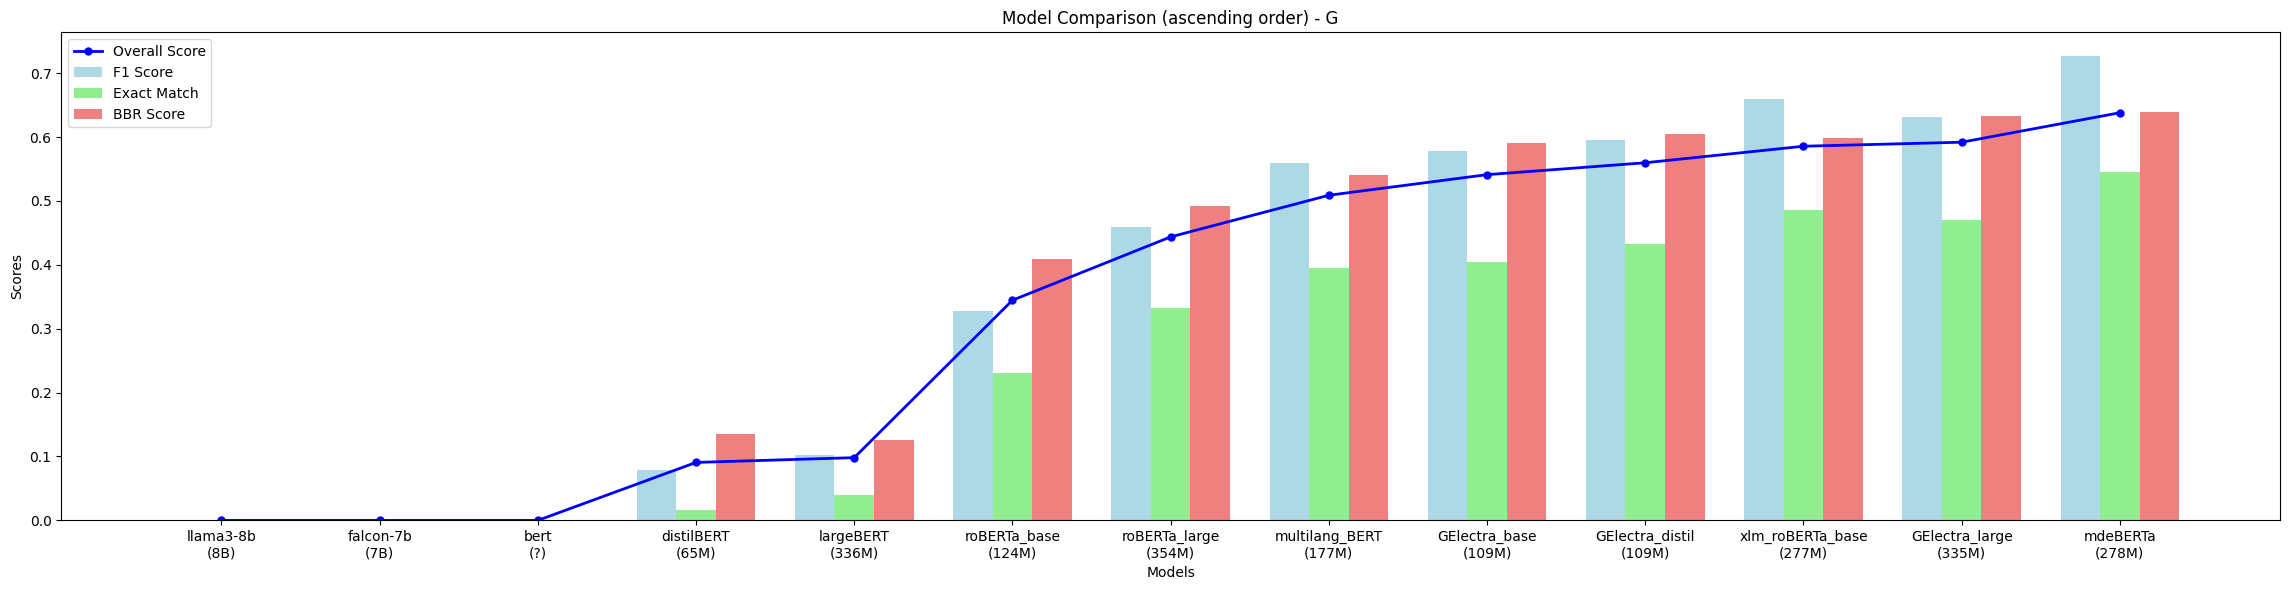

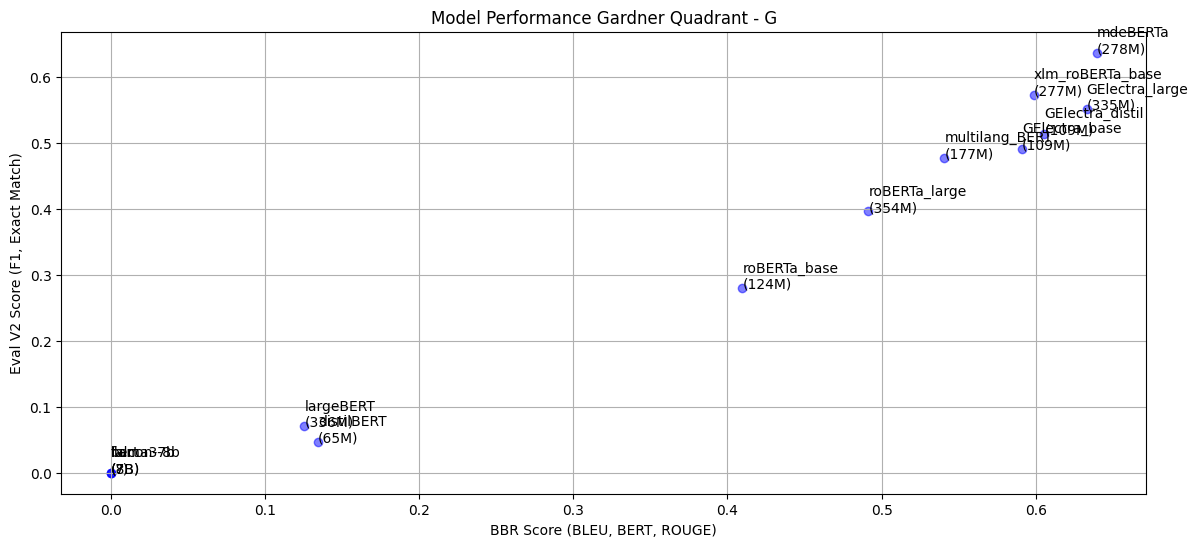

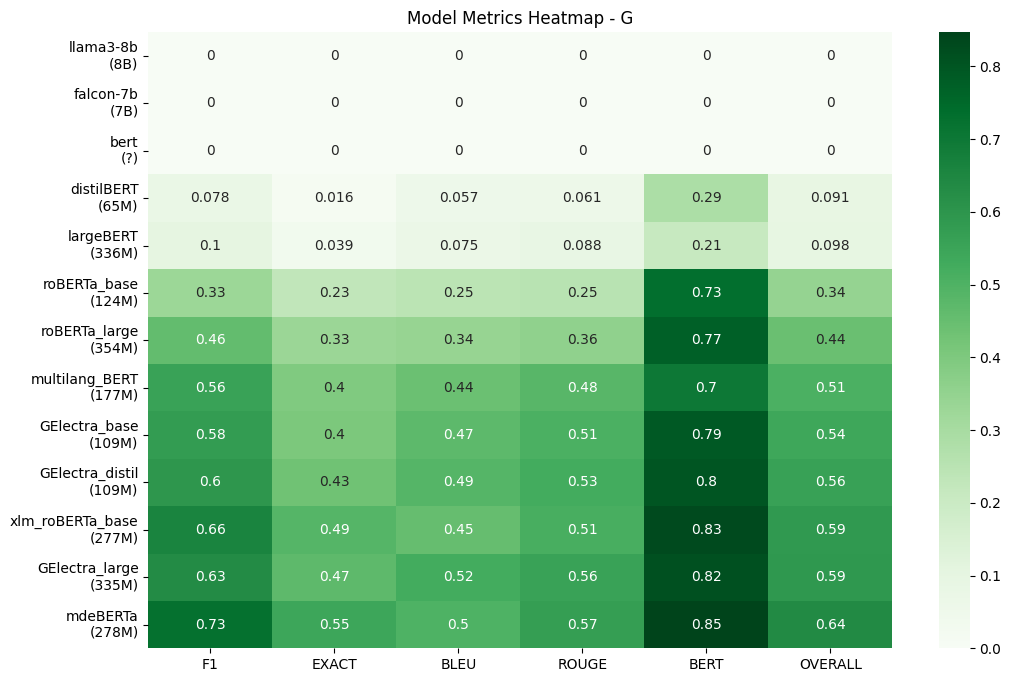

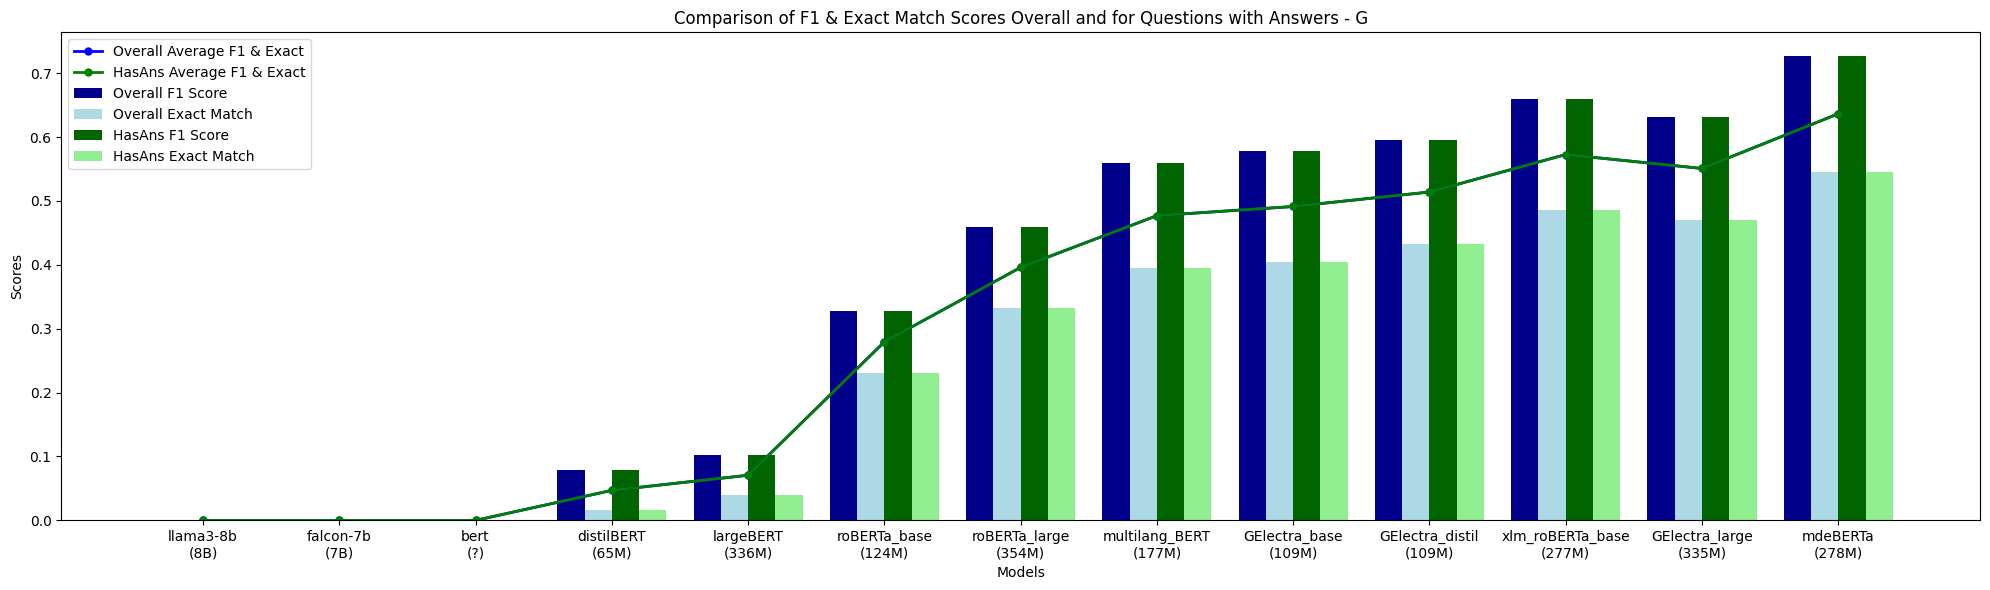

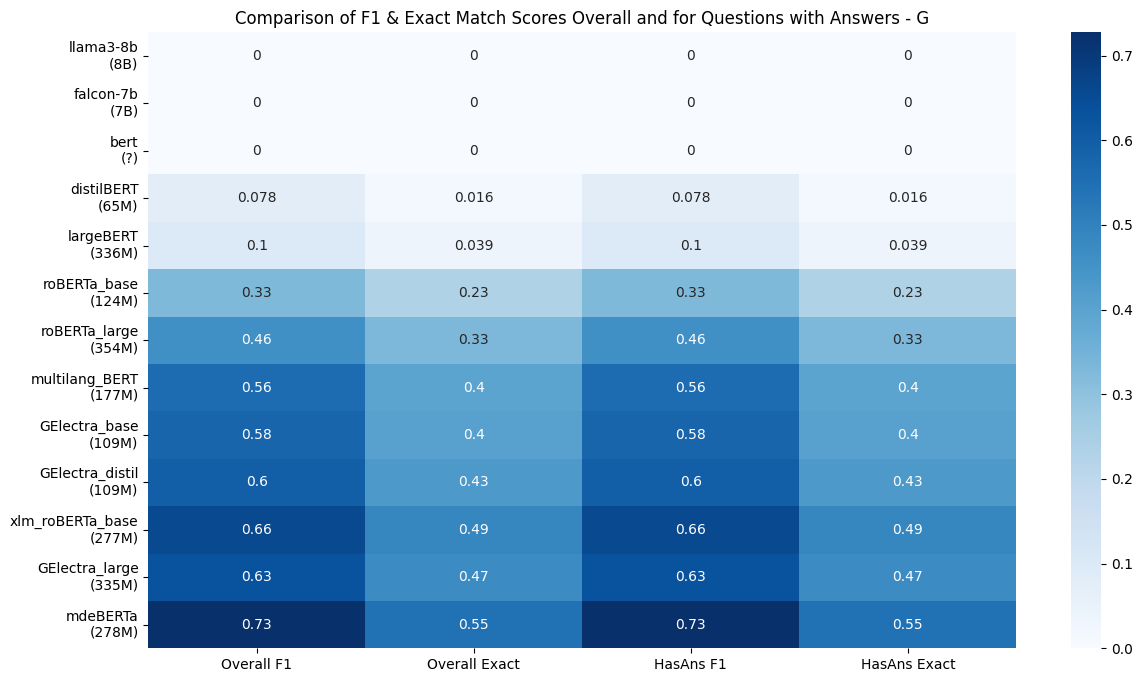

/Users/aminbensaad/eon-llm/llm/scripts/utils/plotting.py:296: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = timing_data.applymap(


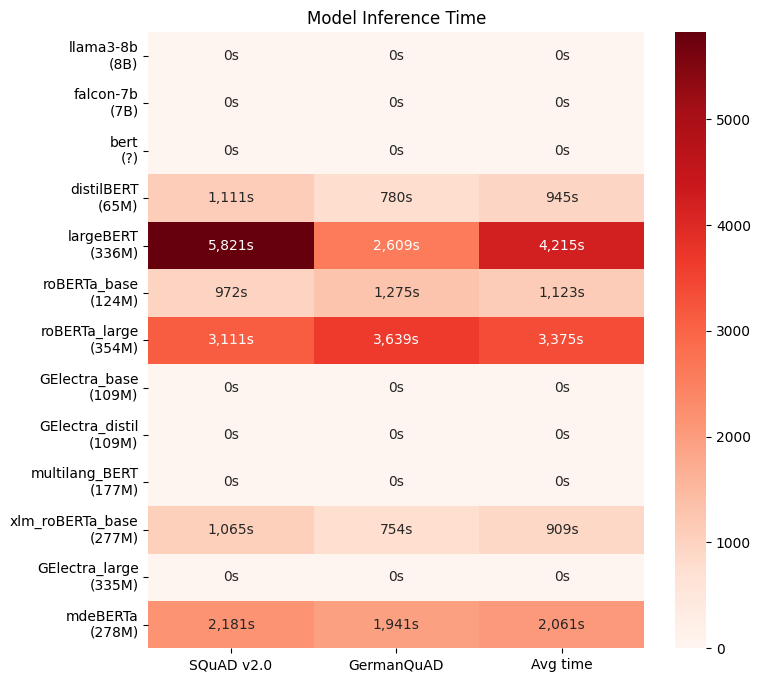

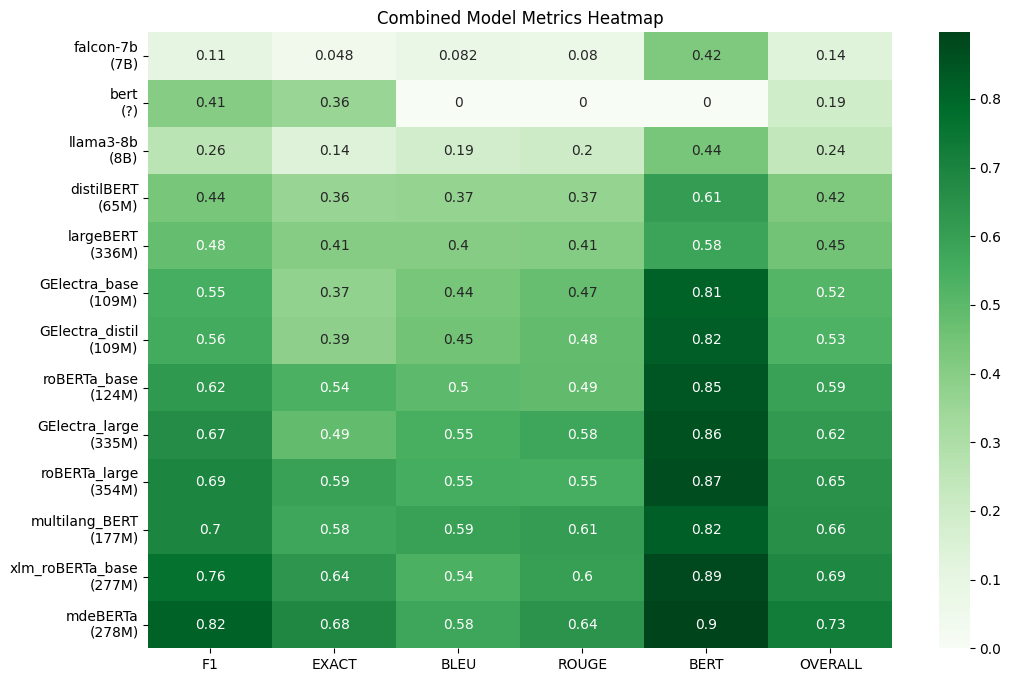

All visualizations have been generated and saved successfully.


In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
from IPython.display import display

# Manual dictionary for model names
manual_model_name_map = {
    # base SQuAD
    "Llama3-ChatQA-1.5-8B": "llama3-8b\n(8B)",
    "falcon-7b-instruct": "falcon-7b\n(7B)",
    # tuned: SQuAD
    "bert": "bert\n(?)",
    "bert-large-cased-whole-word-masking-finetuned-squad": "largeBERT\n(336M)",
    "distilbert-base-cased-distilled-squad": "distilBERT\n(65M)",
    "mdeberta-v3-base-squad2": "mdeBERTa\n(278M)",
    "roberta-base-squad2": "roBERTa_base\n(124M)",
    "roberta-large-squad2": "roBERTa_large\n(354M)",
    "xlm-roberta-base-squad2": "xlm_roBERTa_base\n(277M)",
    # Gtuned: SQuAD
    "bert-multi-english-german-squad2": "multilang_BERT\n(177M)",
    "gelectra-base-germanquad-distilled": "GElectra_distil\n(109M)",
    "gelectra-base-germanquad": "GElectra_base\n(109M)",
    "gelectra-large-germanquad": "GElectra_large\n(335M)",
}

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts')))
import utils.plotting as p

# Datasets
datasets = ["SQuAD", "G"]

# Function to load timing results
def load_timing_results(timing_results_path):
    with open(timing_results_path, 'r') as f:
        timing_results = json.load(f)
    return timing_results

# Function to load json files and extract relevant information
def load_json_files(base_dir, subdirs, datasets):
    results = []
    model_name_map = {}
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        for file_name in os.listdir(subdir_path):
            if file_name.endswith('_eval_results.json'):
                with open(os.path.join(subdir_path, file_name), 'r') as f:
                    data = json.load(f)
                    
                    # Model Name
                    model_name = file_name.replace('_eval_results.json', '')
                    short_name = manual_model_name_map.get(model_name, model_name.split('-')[0])
                    model_name_map[short_name] = model_name
                    
                    for dataset in datasets:
                        # Evaluation script for SQuAD v2 / GermanQuAD
                        eval_v2 = data.get(dataset, {}).get('evaluate-v2', {})
                        exact = eval_v2.get('exact', 0) / 100  # Rescale to 0-1
                        f1 = eval_v2.get('f1', 0) / 100  # Rescale to 0-1
                        
                        # HasAns metrics
                        has_ans_exact = eval_v2.get('HasAns_exact', 0) / 100
                        has_ans_f1 = eval_v2.get('HasAns_f1', 0) / 100
                        
                        # NoAns metrics
                        no_ans_exact = eval_v2.get('NoAns_exact', 0)
                        no_ans_f1 = eval_v2.get('NoAns_f1', 0)
                        
                        # BLEU 
                        bleu_score = data.get(dataset, {}).get('bleu', {}).get('HasAns_bleu', 0)
                        
                        # ROUGE
                        rouge_scores = data.get(dataset, {}).get('rouge', {}).get('HasAns_rouge', {})
                        rouge1 = rouge_scores.get('rouge1', {}).get('f', 0)
                        rouge2 = rouge_scores.get('rouge2', {}).get('f', 0)
                        rougeL = rouge_scores.get('rougeL', {}).get('f', 0)
                        rouge_score = np.mean([rouge1, rouge2, rougeL])
                        
                        # BERT
                        bert_score = data.get(dataset, {}).get('bertscore', {}).get('HasAns_BERTScore', {}).get('F1', 0)
                        
                        # Cumulative scores 
                        eval_v2_score = 1/2 * (exact + f1)
                        eval_v2_score_hasAns =  1/2 * (has_ans_exact + has_ans_f1)
                        eval_other = 1/3 * (bert_score + bleu_score + rouge_score)
                        overall_score = 1/2 * (eval_v2_score_hasAns + eval_other)
                        
                        results.append({
                            'dataset': dataset,
                            'short_name': short_name,
                            'model': model_name,
                            'exact': exact,
                            'f1': f1,
                            'has_ans_exact': has_ans_exact,
                            'has_ans_f1': has_ans_f1,
                            'no_ans_exact': no_ans_exact,
                            'no_ans_f1': no_ans_f1,
                            'bleu_score': bleu_score,
                            'rouge_score': rouge_score,
                            'bert_score': bert_score,
                            'eval_v2_score': eval_v2_score,
                            'eval_v2_score_hasAns': eval_v2_score_hasAns, 
                            'eval_other': eval_other,
                            'overall_score': overall_score
                        })
    return results, model_name_map

# =======================================================================================
# =======================================================================================

# Define the directory paths
base_dir = './eval_results'
figure_root = './figures'
timing_results_path = './timing_results.json'

# Select the subdirectory
subdir = ['base', 'tuned', 'Gtuned'] # options: base, Gbase, tuned, Gtuned

# Load data
data, model_name_map = load_json_files(base_dir, subdir, datasets)

# Load timing results
timing_results = load_timing_results(timing_results_path)

# Create and display DataFrame
df = pd.DataFrame(data)
timing_df = pd.DataFrame.from_dict(timing_results, orient='index').reset_index()
timing_df = timing_df.rename(columns={'index': 'model'})
df = pd.merge(df, timing_df, on='model', how='left')

# Execute visualizations for both datasets
for dataset_name in datasets:
    p.plot_bar_chart_with_line_graph(df, dataset_name, figure_root, manual_model_name_map)
    p.plot_gardner_quadrant(df, dataset_name, figure_root, manual_model_name_map)
    p.plot_heat_map(df, dataset_name, figure_root, manual_model_name_map)
    p.plot_bar_chart_comparison(df, dataset_name, figure_root, manual_model_name_map)
    p.plot_comparison_heat_map(df, dataset_name, figure_root, manual_model_name_map)

p.plot_timing_heat_map(df, figure_root, manual_model_name_map)

# Visualisation 7: Combined Heat map for average values of GermanQuAD and SQuAD
p.plot_combined_heat_map(df, figure_root, manual_model_name_map)

print("All visualizations have been generated and saved successfully.")